# a) Tìm hiểu và nêu các bước trong phát hiện biên bằng Canny

## Các bước thực hiện phát hiện cạnh Canny là:

## Tiền xử lý hình ảnh - Noise reduction
## Tính toán độ dốc(gradient)
## Non-max suppression
## Ngưỡng kép
## Edge tracking by Hysteresis

# b) Viết code cho phương pháp Canny (có giải thích chi tiết)

## đoạn code dưới đây nhằm tính toán gradient cho ảnh , sử dụng kernel sobel 3x3

In [73]:
from scipy import ndimage
import numpy  as np
from scipy.signal import convolve2d

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = convolve2d(img,Kx,mode="same")
    Iy = convolve2d(img,Ky,mode="same")
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

## Nguyên lý : thuật toán sẽ duyệt qua tất cả các điểm trên ma trận cường độ gradient và tìm các pixel có giá trị lớn nhất theo hướng cạnh.
## Mỗi pixel có 2 tiêu chí chính (hướng cạnh tính bằng radian và cường độ pixel (từ 0–255)). Dựa trên các đầu vào này, các bước gồm :

##      Tạo một ma trận được khởi tạo bằng 0 có cùng kích thước với ma trận cường độ gradient ban đầu;
##      Xác định hướng cạnh dựa trên giá trị góc từ ma trận góc;
##      Kiểm tra xem pixel cùng hướng có cường độ cao hơn pixel đang được xử lý hay không;
##      Trả về hình ảnh đã  được xử lý

## giải thích tại sao ta không xét đủ 1 vòng tròn lượng giác mà chỉ xét nửa vòng tròn ( 0 đến 180)
## vì ta xét 3 pixel trên cùng một phương của direction gradient tại vị trí (i,j) (không xét direction gradient tại vị trí (i,j) có hướng từ [i, j+1] đến [i, j-1] hay có hướng ngược lại ( đối với trường hợp góc hợp giữa vector gradient tại vị trí (i,j) so với trục x từ[0,22.5) hoặc[157.5,180] ))

## việc sử dụng cấu trúc try ... except là để loại bỏ các trường hợp vượt quá index của ảnh khi xét đến các pixel ngoài cùng

## giải thích các con số được sử dụng để xác định 2 pixel liền kề so với pixel đang xét :
## trong trường hợp đầu tiên ta cần xét những góc hợp nào giữa vector gradient tại vị trí (i,j) so với trục x cho 2 vị trí liền kề là [i,j+1] và [i,j-1] , con số 0 là góc hợp khi vetor gardient có cùng phương so vói phương của trục x , con số 22.5 là góc hợp khi vetor gardient có lệch  phương một góc 22.5 độ so với phương  của trục x . tương tự cho các con số khác . trường hợp đầu tiên là trường hợp đặc biệt phải xét đến 4 góc lệch vì cả 2 vị trí liền kề là [i,j+1] và [i,j-1]  cùng nằm trên một nủa đường tròn đang được xét

In [74]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

# Bước ngưỡng kép nhằm mục đích xác định 3 loại pixel: mạnh, yếu và không liên quan:

## Điểm ảnh mạnh là điểm ảnh có cường độ cao đến mức chúng ta chắc chắn rằng chúng góp phần tạo nên cạnh cuối cùng.
## Điểm ảnh yếu là điểm ảnh có giá trị cường độ không đủ để được coi là điểm ảnh mạnh, nhưng cũng không đủ nhỏ để được coi là không liên quan đến việc phát hiện cạnh.
## Các điểm ảnh khác được coi là không liên quan đến cạnh.

In [75]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09,Tlow= np.int32(25),Tup=np.int32(255)):
    
    highThreshold = img.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = Tlow
    strong = Tup
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)


##  Theo dõi cạnh bằng Hysteresis bao gồm việc chuyển đổi các điểm ảnh yếu thành điểm ảnh mạnh nếu và chỉ nếu ít nhất một điểm ảnh xung quanh điểm ảnh đang được xử lý là điểm ảnh mạnh

In [76]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

# c) Dùng hình ‘Lena.jpg’ để so sánh kết quả của hàm tự viết với thư viện (cv2.Canny)

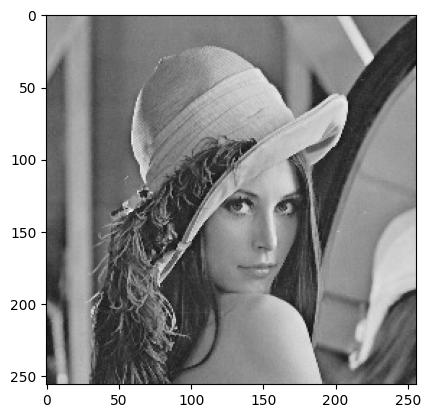

In [77]:
import cv2
import matplotlib.pyplot as plt

img= cv2.imread("D:\imageprocessing\Lena.jpg",0)
plt.imshow(img,"gray")


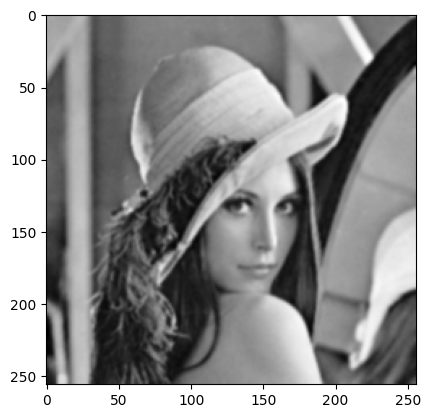

In [78]:
img_blur=ndimage.gaussian_filter(img,sigma=1)
plt.imshow(img_blur,"gray")

In [79]:
G,theta=sobel_filters(img_blur)

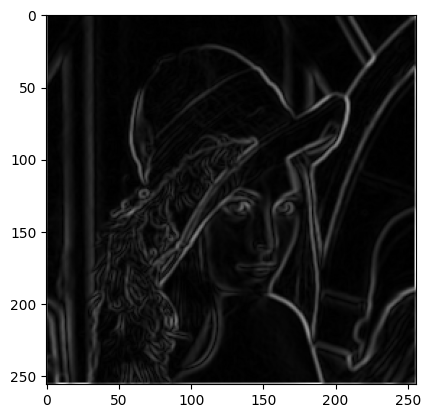

In [80]:
plt.imshow(G,"gray")

In [81]:
G_sharp=non_max_suppression(G,theta)

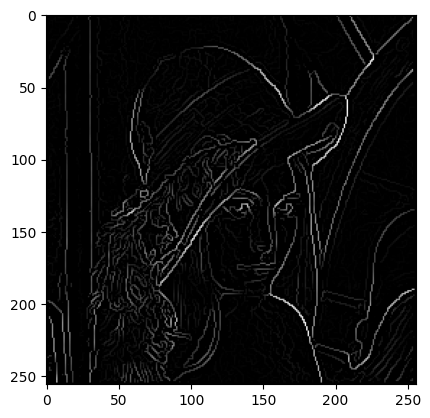

In [82]:
plt.imshow(G_sharp,"gray")

In [83]:
res,weak,strong=threshold(G_sharp)

In [84]:
img_final=hysteresis(res,weak,255)

In [88]:
img_final_cv2=cv2.Canny(img,weak,255)

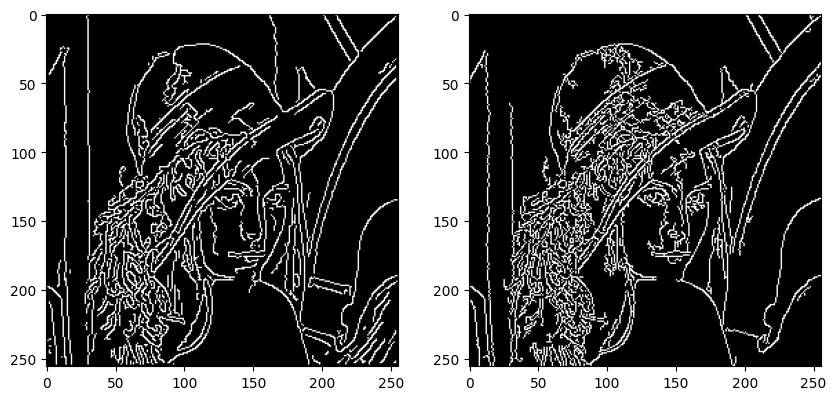

In [89]:
plt.figure(figsize=(10,15))
plt.subplot(121)
plt.imshow(img_final,"gray")
plt.subplot(122)
plt.imshow(img_final_cv2,"gray")

# nhận xét : sử dụng thư viện cho ra kết quả chính xác hơn , các cạnh được nối với nhau một cách liền mạch và đúng về hình dáng của cạnh trong ảnh gốc , ngoài ra thì tốc độ xử lý cũng nhanh hơn.